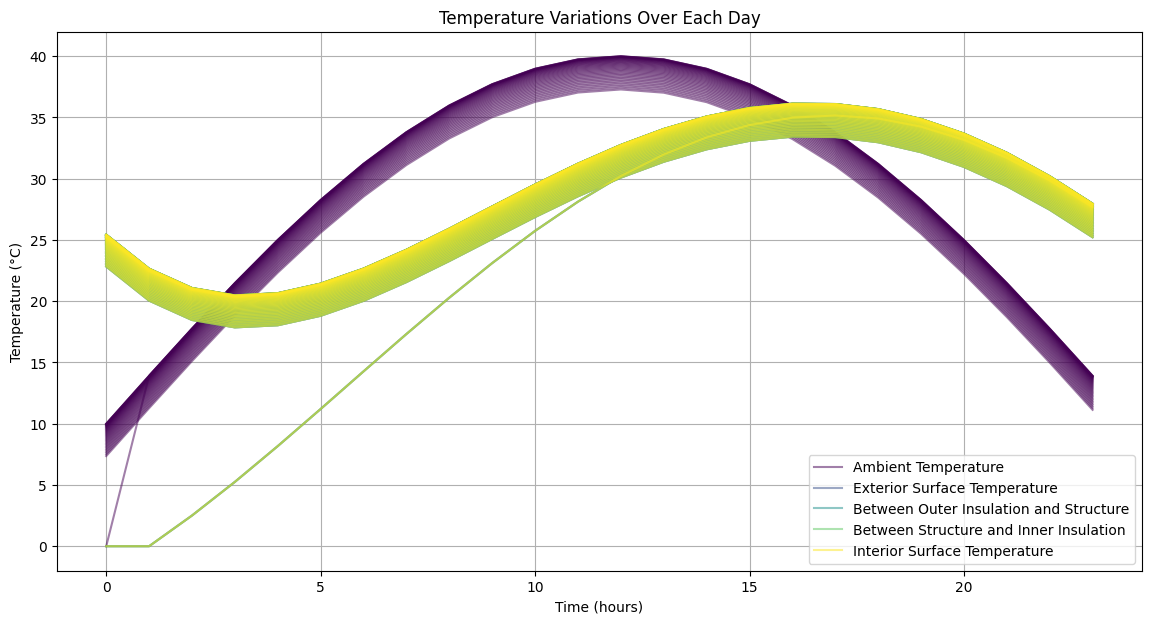

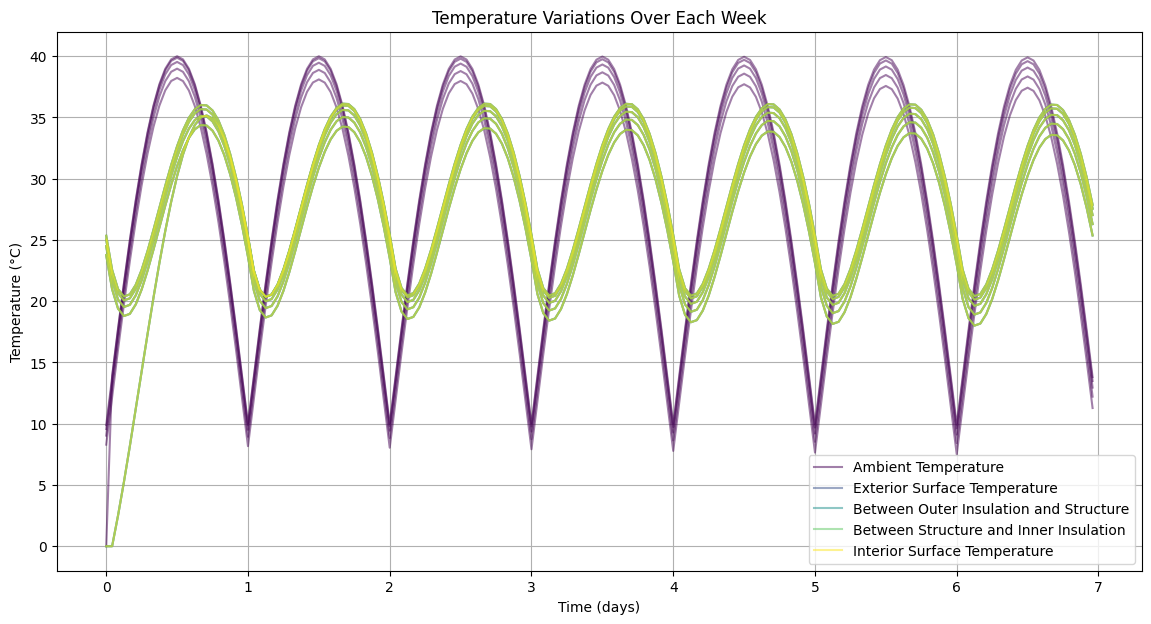

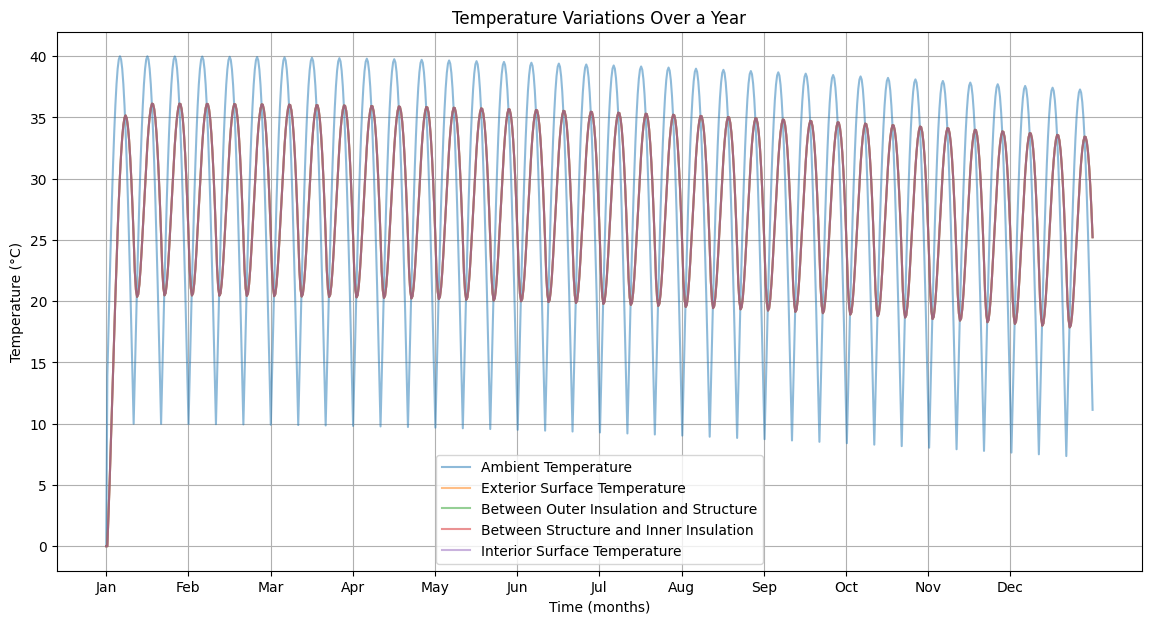

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# Constants and parameters
T_initial = 0  # Initial temperature in °C for all layers
T_ambient_max = 25  # Maximum ambient temperature in °C
T_ambient_min = -5  # Minimum ambient temperature in °C
solar_irradiance_max = 1000  # Maximum solar irradiance in W/m²
solar_irradiance_min = 0  # Minimum solar irradiance at night in W/m²
R_int = 1  # Internal insulation R-value (m²·K/W)
R_struct = 0.5  # Structural layer R-value (m²·K/W)
R_ext = 1  # External insulation R-value (m²·K/W)
A_struct = 50  # Surface area of the structure in m²
time_step = 3600  # Time step in seconds (1 hour)
total_time = 36 * 24 * 3600  # Total simulation time (1 year in seconds)
absorptivity = 0.7  # Fraction of solar irradiance absorbed by the structure
heat_capacity_ext = 1000  # Heat capacity in J/(kg·K) for exterior layer
heat_capacity_struct = 2000  # Heat capacity in J/(kg·K) for structural layer
heat_capacity_int = 1000  # Heat capacity in J/(kg·K) for interior layer
mass_ext = 200  # Mass of the exterior layer in kg
mass_struct = 2000  # Mass of the structural layer in kg
mass_int = 200  # Mass of the interior layer in kg

# Derived parameters
R_total = R_int + R_struct + R_ext  # Total R-value

# Arrays to store temperature data
time_points = int(total_time / time_step)
T_ext_surface = np.zeros(time_points)
T_between_ext_and_struct = np.zeros(time_points)
T_between_struct_and_int = np.zeros(time_points)
T_int_surface = np.zeros(time_points)
T_ambient = np.zeros(time_points)
solar_irradiance = np.zeros(time_points)

# Initial conditions
T_ext_surface[0] = T_initial
T_between_ext_and_struct[0] = T_initial
T_between_struct_and_int[0] = T_initial
T_int_surface[0] = T_initial

# Function to calculate ambient temperature based on a synthetic daily and annual cycle
def ambient_temperature(t):
    day_of_year = (t % (365 * 24 * 3600)) / (24 * 3600)
    time_of_day = (t % (24 * 3600)) / 3600
    daily_temp_variation = (T_ambient_max - T_ambient_min) * np.sin(np.pi * time_of_day / 24)
    annual_temp_variation = (T_ambient_max - T_ambient_min) / 2 * np.cos(2 * np.pi * day_of_year / 365)
    return T_ambient_min + daily_temp_variation + annual_temp_variation

# TODO Function to calculate solar irradiance based on a synthetic daily and annual cycle
def solar_irradiance_value(t):
    day_of_year = (t % (365 * 24 * 3600)) / (24 * 3600)
    time_of_day = (t % (24 * 3600)) / 3600
    daily_variation = (solar_irradiance_max - solar_irradiance_min) * np.sin(np.pi * time_of_day / 24)
    annual_variation = (solar_irradiance_max - solar_irradiance_min) / 2 * np.cos(2 * np.pi * day_of_year / 365)
    return 0#solar_irradiance_min + daily_variation + annual_variation

# Simulation loop
for t in range(1, time_points):
    current_time = t * time_step
    
    # Update ambient temperature and solar irradiance
    T_ambient[t] = ambient_temperature(current_time)
    solar_irradiance[t] = solar_irradiance_value(current_time)
    
    # Calculate heat transfer
    Q_solar = absorptivity * solar_irradiance[t] * A_struct  # Solar absorption
    Q_cond_ext = (T_ext_surface[t-1] - T_ambient[t-1]) / R_ext  # Conduction through external insulation
    Q_cond_struct = (T_between_ext_and_struct[t-1] - T_ext_surface[t-1]) / R_struct  # Conduction through structure
    Q_cond_int = (T_between_struct_and_int[t-1] - T_between_ext_and_struct[t-1]) / R_int  # Conduction through internal insulation
    
    # Update temperatures (considering thermal mass and time step)
    T_ext_surface[t] = T_ext_surface[t-1] + (Q_solar - Q_cond_ext) * time_step / (mass_struct * heat_capacity)
    T_between_ext_and_struct[t] = T_ext_surface[t] - Q_cond_struct * time_step / (mass_struct * heat_capacity)
    T_between_struct_and_int[t] = T_between_ext_and_struct[t] - Q_cond_int * time_step / (mass_struct * heat_capacity)
    T_int_surface[t] = T_between_struct_and_int[t]

def overlay_plot(data_dict, period_length, period_name, x_units):
    periods = int(total_time / (period_length * time_step))
    if periods < 1:
        return
    
    plt.figure(figsize=(14, 7))
    for label, data in data_dict.items():
        for i in range(periods):
            start_idx = i * period_length
            end_idx = (i + 1) * period_length
            plt.plot(np.arange(0, period_length) * time_step / (3600 if x_units == 'hours' else 24 * 3600 if x_units == 'days' else 1), data[start_idx:end_idx], alpha=0.5, label=label if i == 0 else "")
    
    plt.xlabel(f'Time ({x_units})')
    plt.ylabel('Temperature (°C)')
    plt.title(f'Temperature Variations Over Each {period_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

def smooth_and_downsample(data, factor):
    if factor <= 1:
        return data
    smoothed_data = np.convolve(data, np.ones(factor) / factor, mode='valid')
    downsampled_data = smoothed_data[::factor]
    return downsampled_data

def annual_plot(data_dict, granularity=0.1):
    # Downsampling factor
    factor = int(1.0 / granularity)
    if factor < 1:
        factor = 1
    
    # Create the plot
    plt.figure(figsize=(14, 7))
    for label, data in data_dict.items():
        smoothed_data = smooth_and_downsample(data, factor)
        # Stretch the x data to fill the entire timespan
        x_data = np.linspace(0, 12, len(smoothed_data))
        plt.plot(x_data, smoothed_data, alpha=0.5, label=label)
    
    plt.xlabel('Time (months)')
    plt.ylabel('Temperature (°C)')
    plt.title('Temperature Variations Over a Year')
    plt.xticks(np.arange(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.legend()
    plt.grid(True)
    plt.show()

def overlay_plot(data_dict, period_length, period_name, x_units):
    periods = int(total_time / (period_length * time_step))
    if periods < 1:
        return
    
    plt.figure(figsize=(14, 7))
    colors = plt.cm.viridis(np.linspace(0, 1, len(data_dict)))
    for idx, (label, data) in enumerate(data_dict.items()):
        color = colors[idx]
        for i in range(periods):
            start_idx = i * period_length
            end_idx = (i + 1) * period_length
            plt.plot(np.arange(0, period_length) * time_step / (3600 if x_units == 'hours' else 24 * 3600), 
                     data[start_idx:end_idx], alpha=0.5, label=label if i == 0 else "", color=color)
    
    plt.xlabel(f'Time ({x_units})')
    plt.ylabel('Temperature (°C)')
    plt.title(f'Temperature Variations Over Each {period_name}')
    plt.legend()
    plt.grid(True)
    plt.show()


data_dict = {
    'Ambient Temperature': T_ambient,
    'Exterior Surface Temperature': T_ext_surface,
    'Between Outer Insulation and Structure': T_between_ext_and_struct,
    'Between Structure and Inner Insulation': T_between_struct_and_int,
    'Interior Surface Temperature': T_int_surface
}

overlay_plot(data_dict, 24, 'Day', 'hours')
overlay_plot(data_dict, 24*7, 'Week', 'days')
annual_plot(data_dict, granularity=1.0)